# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#Using a custom datadir, because my jupyter notebook runs with a home dire mounted a NFS mount point
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

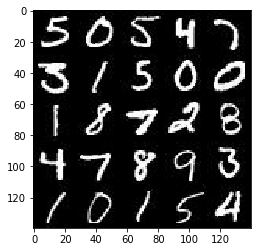

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

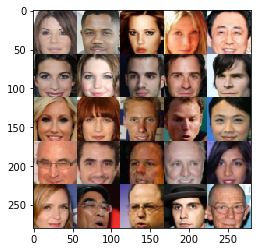

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 56, 56, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    #Real input shape: (batch_size, width, height, channels)
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    #z input shape: (batch_size, z_dim)
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Discriminator take as input 28x28xnum_channels
        #Shouldn't use batch normalization in the first discriminator conv layer
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                                 padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        #Leaky RELU
        conv1 =  tf.maximum(alpha * conv1, conv1)
        #Implement dropout with low drop_rate, discriminator only used in training, dropout always present
        conv1 = tf.nn.dropout(conv1, keep_prob=0.7)
        
        #14x14x64
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, 
                                 padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        #Batch norm
        #Discriminator is used only for training -> training always True
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        conv2 = tf.nn.dropout(conv2, keep_prob=0.7)
        
        #7x7x128
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=1, padding='same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        #Batch norm
        #Discriminator is used only for training -> training always True
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        conv3 = tf.nn.dropout(conv3, keep_prob=0.7,)
        
        #7x7*256
        #Flatten layer
        flat = tf.reshape(conv2, (-1, 7*7*256))
        #Logits and output
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #(not is_train): if it's train do not reuse variable if it's not reuse them
    with tf.variable_scope('generator', reuse=(not is_train)):
        #Fully connect and z connection to transpose conv pyramid
        #Land in 7x7x256
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        #Batch norm and LRELU
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        
        #Transpose convolution
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #Dropout only if it's train
        if is_train:
            x2 = tf.nn.dropout(x2, keep_prob=0.7)
        #Now (14,14,256)
        
        #Transpose convolution
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        x3= tf.layers.batch_normalization(x3, training=is_train)
        x3= tf.maximum(alpha * x3, x3)
        if is_train:
            x3 = tf.nn.dropout(x3, keep_prob=0.7)
        #Now (28,28,128)
        
        #Transpose convolution
        #Already in 28x28, strides must be 1
        x4 = tf.layers.conv2d_transpose(x3, 56, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))
        x4= tf.layers.batch_normalization(x4, training=is_train)
        x4= tf.maximum(alpha * x4, x4)
        if is_train:
            x4 = tf.nn.dropout(x4, keep_prob=0.7)
        
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Label smoothing
    real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
        # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    #data_shape[1:] beacuse model inputs doesn't expect batch size as input
    input_real, input_z, learn_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    if data_image_mode == 'L':
        out_channels_dim = 1
    else:
        out_channels_dim = 3
    d_loss, g_loss = model_loss(input_real, input_z, out_channels_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        steps = 0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                #Normalize input
                batch_images = batch_images * 2
                #Generate random unifrom z vector
                batch_z = np.random.uniform(-1 , 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate_tensor: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate_tensor: learning_rate})
                
                #Print stats
                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    
                if steps % 200 == 0:
                    show_generator_output(sess, 25, input_z, out_channels_dim, data_image_mode)
        saver.save(sess, './generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4013... Generator Loss: 3.1932
Epoch 1/2... Discriminator Loss: 0.4498... Generator Loss: 3.2865
Epoch 1/2... Discriminator Loss: 0.4071... Generator Loss: 3.3478
Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 3.9517


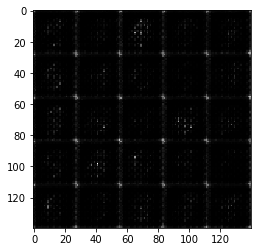

Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 3.4138
Epoch 1/2... Discriminator Loss: 0.4276... Generator Loss: 3.9133
Epoch 1/2... Discriminator Loss: 0.4254... Generator Loss: 4.3950
Epoch 1/2... Discriminator Loss: 0.3985... Generator Loss: 3.1876


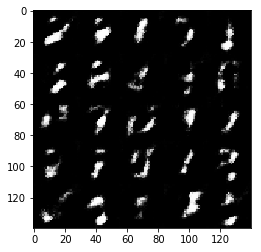

Epoch 1/2... Discriminator Loss: 0.4273... Generator Loss: 3.4083
Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 3.2569
Epoch 1/2... Discriminator Loss: 0.4044... Generator Loss: 3.6417
Epoch 1/2... Discriminator Loss: 0.3924... Generator Loss: 3.4362


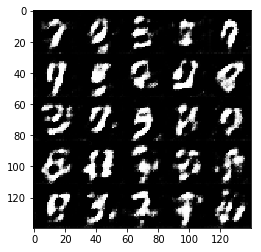

Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 3.1228
Epoch 1/2... Discriminator Loss: 0.4161... Generator Loss: 3.1263
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 3.1246
Epoch 1/2... Discriminator Loss: 0.4120... Generator Loss: 2.8986


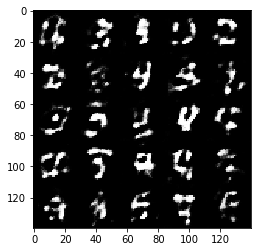

Epoch 1/2... Discriminator Loss: 0.4132... Generator Loss: 3.4749
Epoch 1/2... Discriminator Loss: 0.4025... Generator Loss: 3.3562
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 2.9681
Epoch 1/2... Discriminator Loss: 0.3979... Generator Loss: 2.8757


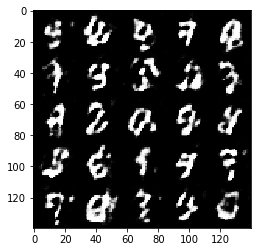

Epoch 1/2... Discriminator Loss: 0.3930... Generator Loss: 2.9907
Epoch 1/2... Discriminator Loss: 0.4054... Generator Loss: 2.9234
Epoch 1/2... Discriminator Loss: 0.4275... Generator Loss: 3.4623
Epoch 1/2... Discriminator Loss: 0.3886... Generator Loss: 3.5019


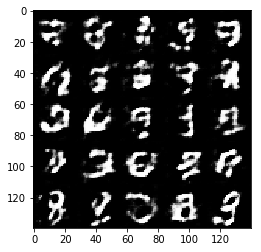

Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 3.1266
Epoch 1/2... Discriminator Loss: 0.4079... Generator Loss: 3.5477
Epoch 1/2... Discriminator Loss: 0.4122... Generator Loss: 3.1743
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 3.5682


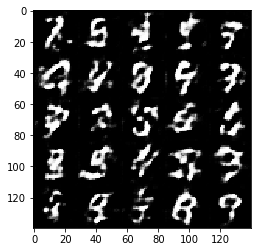

Epoch 1/2... Discriminator Loss: 0.4158... Generator Loss: 3.2972
Epoch 1/2... Discriminator Loss: 0.3907... Generator Loss: 3.3610
Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 3.2075
Epoch 1/2... Discriminator Loss: 0.4066... Generator Loss: 3.1691


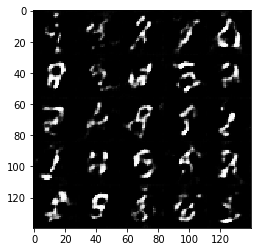

Epoch 1/2... Discriminator Loss: 0.3968... Generator Loss: 3.0315
Epoch 1/2... Discriminator Loss: 0.4171... Generator Loss: 3.1194
Epoch 1/2... Discriminator Loss: 0.3862... Generator Loss: 3.1704
Epoch 1/2... Discriminator Loss: 0.3875... Generator Loss: 3.5665


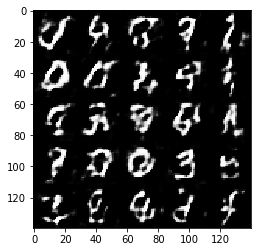

Epoch 1/2... Discriminator Loss: 0.3992... Generator Loss: 3.2563
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 3.2039
Epoch 1/2... Discriminator Loss: 0.3990... Generator Loss: 3.1443
Epoch 1/2... Discriminator Loss: 0.3969... Generator Loss: 3.1077


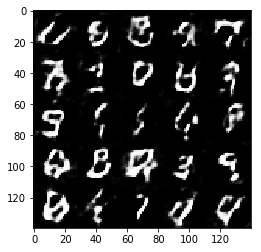

Epoch 1/2... Discriminator Loss: 0.3834... Generator Loss: 3.3575
Epoch 1/2... Discriminator Loss: 0.4036... Generator Loss: 2.9588
Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 3.6583
Epoch 1/2... Discriminator Loss: 0.3865... Generator Loss: 3.3784


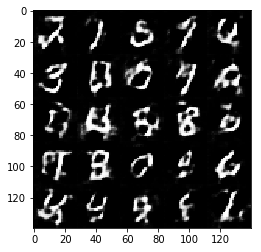

Epoch 1/2... Discriminator Loss: 0.4108... Generator Loss: 3.0323
Epoch 1/2... Discriminator Loss: 0.3976... Generator Loss: 3.6244
Epoch 1/2... Discriminator Loss: 0.3873... Generator Loss: 3.1488
Epoch 1/2... Discriminator Loss: 0.3927... Generator Loss: 3.5677


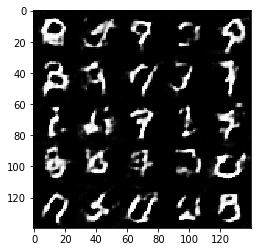

Epoch 1/2... Discriminator Loss: 0.4077... Generator Loss: 3.1110
Epoch 1/2... Discriminator Loss: 0.3924... Generator Loss: 3.2571
Epoch 2/2... Discriminator Loss: 0.4003... Generator Loss: 3.3059
Epoch 2/2... Discriminator Loss: 0.3997... Generator Loss: 3.3124


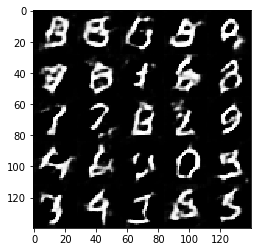

Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 3.2053
Epoch 2/2... Discriminator Loss: 0.3931... Generator Loss: 3.2266
Epoch 2/2... Discriminator Loss: 0.3940... Generator Loss: 3.4176
Epoch 2/2... Discriminator Loss: 0.3796... Generator Loss: 3.4975


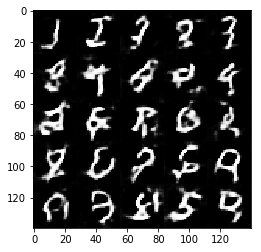

Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 3.2663
Epoch 2/2... Discriminator Loss: 0.4036... Generator Loss: 3.3408
Epoch 2/2... Discriminator Loss: 0.3951... Generator Loss: 3.1622
Epoch 2/2... Discriminator Loss: 0.4052... Generator Loss: 3.8170


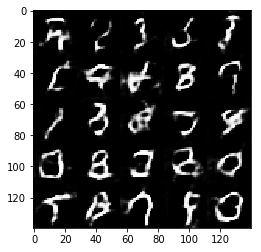

Epoch 2/2... Discriminator Loss: 0.4199... Generator Loss: 3.3430
Epoch 2/2... Discriminator Loss: 0.3970... Generator Loss: 2.9079
Epoch 2/2... Discriminator Loss: 0.3966... Generator Loss: 2.9895
Epoch 2/2... Discriminator Loss: 0.3942... Generator Loss: 3.4213


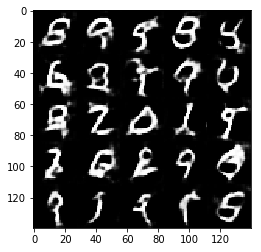

Epoch 2/2... Discriminator Loss: 0.4073... Generator Loss: 3.5592
Epoch 2/2... Discriminator Loss: 0.3968... Generator Loss: 3.3949
Epoch 2/2... Discriminator Loss: 0.4071... Generator Loss: 2.9331
Epoch 2/2... Discriminator Loss: 0.3994... Generator Loss: 3.3633


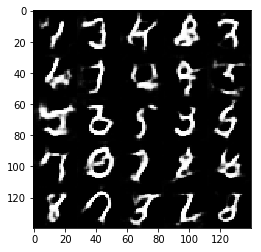

Epoch 2/2... Discriminator Loss: 0.3919... Generator Loss: 3.0612
Epoch 2/2... Discriminator Loss: 0.3783... Generator Loss: 3.5563
Epoch 2/2... Discriminator Loss: 0.3900... Generator Loss: 3.3253
Epoch 2/2... Discriminator Loss: 0.4003... Generator Loss: 2.8756


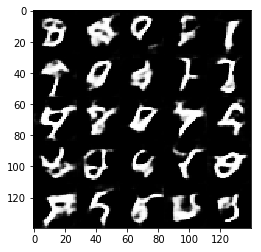

Epoch 2/2... Discriminator Loss: 0.4019... Generator Loss: 3.1598
Epoch 2/2... Discriminator Loss: 0.4012... Generator Loss: 3.1263
Epoch 2/2... Discriminator Loss: 0.3764... Generator Loss: 3.0459
Epoch 2/2... Discriminator Loss: 0.3874... Generator Loss: 3.3223


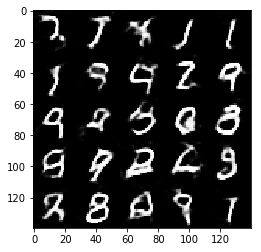

Epoch 2/2... Discriminator Loss: 0.3992... Generator Loss: 3.1545
Epoch 2/2... Discriminator Loss: 0.3782... Generator Loss: 2.9653
Epoch 2/2... Discriminator Loss: 0.4078... Generator Loss: 3.1654
Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 3.1494


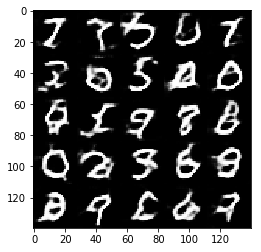

Epoch 2/2... Discriminator Loss: 0.3862... Generator Loss: 3.6819
Epoch 2/2... Discriminator Loss: 0.3960... Generator Loss: 3.2348
Epoch 2/2... Discriminator Loss: 0.3926... Generator Loss: 2.9405
Epoch 2/2... Discriminator Loss: 0.3983... Generator Loss: 3.4248


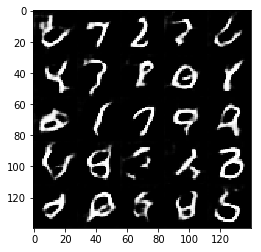

Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 3.1932
Epoch 2/2... Discriminator Loss: 0.3991... Generator Loss: 2.8387
Epoch 2/2... Discriminator Loss: 0.3972... Generator Loss: 3.1233
Epoch 2/2... Discriminator Loss: 0.3995... Generator Loss: 2.9711


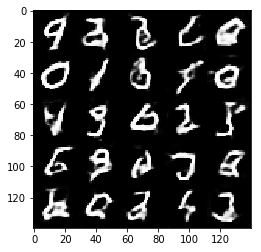

Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 3.4748
Epoch 2/2... Discriminator Loss: 0.3869... Generator Loss: 2.9309
Epoch 2/2... Discriminator Loss: 0.3892... Generator Loss: 3.1389
Epoch 2/2... Discriminator Loss: 0.3910... Generator Loss: 3.1544


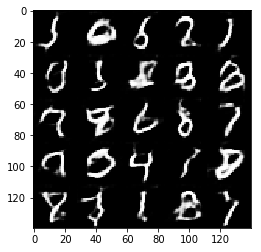

Epoch 2/2... Discriminator Loss: 0.4026... Generator Loss: 2.9487
Epoch 2/2... Discriminator Loss: 0.3935... Generator Loss: 3.5063
Epoch 2/2... Discriminator Loss: 0.3832... Generator Loss: 2.9606
Epoch 2/2... Discriminator Loss: 0.4127... Generator Loss: 3.4152


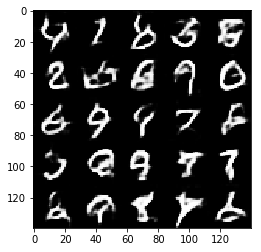

Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 3.1856
Epoch 2/2... Discriminator Loss: 0.3925... Generator Loss: 3.3204
Epoch 2/2... Discriminator Loss: 0.3999... Generator Loss: 3.5168
Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 3.3237


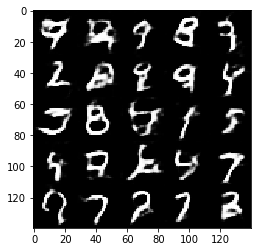

In [12]:
batch_size = 24
z_dim = 100
learning_rate = 0.0001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 2.9121
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 4.2019
Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 3.7411
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 3.9376


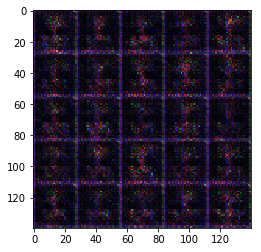

Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 4.0964
Epoch 1/1... Discriminator Loss: 0.3915... Generator Loss: 4.7938
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 4.9146
Epoch 1/1... Discriminator Loss: 0.3509... Generator Loss: 5.0731


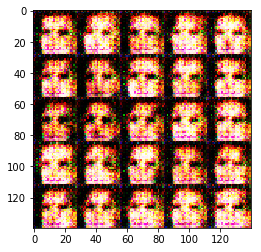

Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 4.9963
Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 4.2433
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 4.8663
Epoch 1/1... Discriminator Loss: 0.3596... Generator Loss: 4.5486


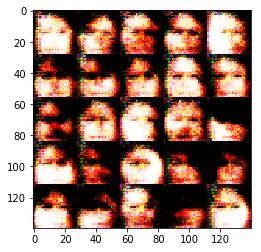

Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 4.5473
Epoch 1/1... Discriminator Loss: 0.3679... Generator Loss: 4.3834
Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 5.2827
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 4.2057


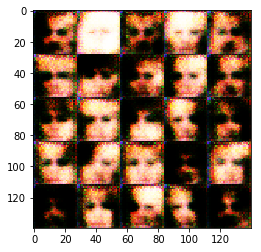

Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 5.1416
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 4.0024
Epoch 1/1... Discriminator Loss: 0.3778... Generator Loss: 4.2864
Epoch 1/1... Discriminator Loss: 0.3597... Generator Loss: 4.6135


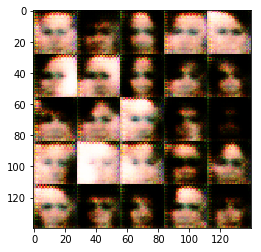

Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 4.5171
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 4.3011
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 4.4541
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 4.6139


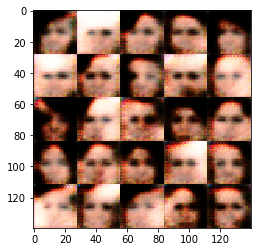

Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 4.8249
Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 5.5252
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 4.0305
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 4.0835


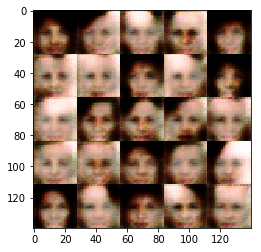

Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 4.4375
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 4.6366
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 3.7638
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 4.5199


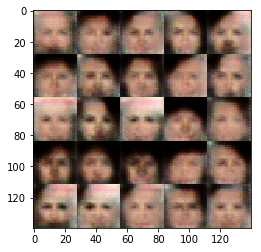

Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 3.8543
Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 3.9635
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 3.7240
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.4151


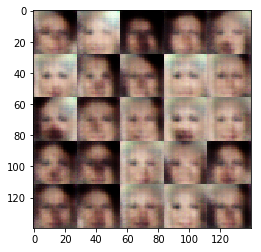

Epoch 1/1... Discriminator Loss: 0.3792... Generator Loss: 3.2414
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 2.7035
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 3.8075
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 2.8999


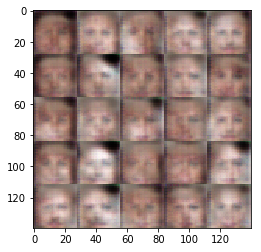

Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 3.7809
Epoch 1/1... Discriminator Loss: 0.3708... Generator Loss: 3.4822
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 3.7163
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 3.2695


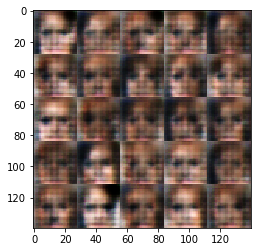

Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 3.6089
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 4.0534
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 3.3760
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 4.0781


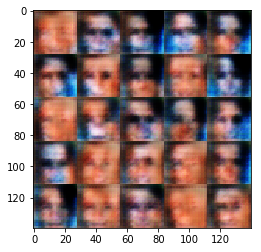

Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 3.3546
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 3.4662
Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 3.8004
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 3.7175


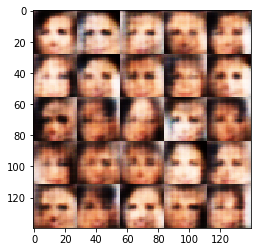

Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 3.6469
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 3.2450
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.4075
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 3.3866


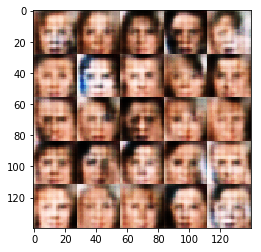

Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 3.2915
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 3.0920
Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 3.2502
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 3.2751


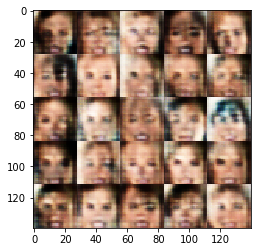

Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 2.9963
Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 3.1428
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 3.0992
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 3.1723


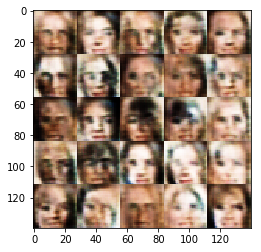

Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 3.1551
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 3.2005
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.0696
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 3.2402


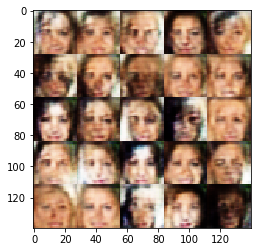

Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 3.2108
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 3.2702
Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 2.9842
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 2.9811


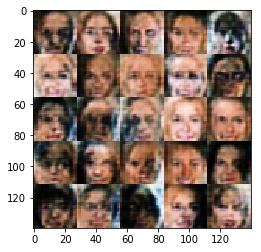

Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 3.3765
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 3.0548
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 2.7608
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 3.2669


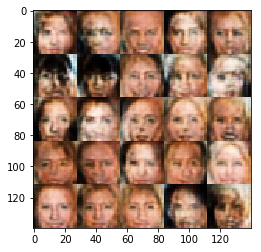

Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 3.1045
Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 3.2162
Epoch 1/1... Discriminator Loss: 0.4398... Generator Loss: 2.8216
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 3.1456


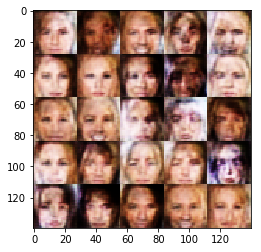

Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 3.0044
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 3.1470
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 2.7258
Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 2.9282


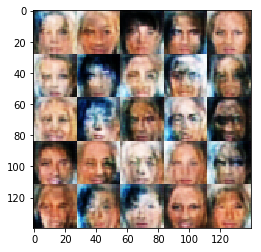

Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 2.8879
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 3.0552
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 3.1534
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 2.8710


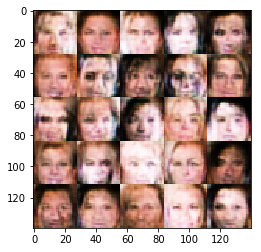

Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 2.9363
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 2.6856
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.2680
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 2.9964


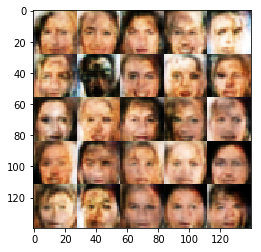

Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 2.9450
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.1331
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 3.5063
Epoch 1/1... Discriminator Loss: 0.4150... Generator Loss: 3.1301


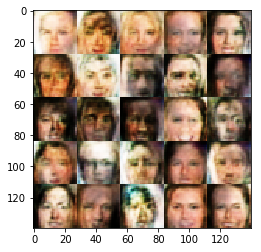

Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 2.7985
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.0621
Epoch 1/1... Discriminator Loss: 0.4233... Generator Loss: 3.0874
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.1624


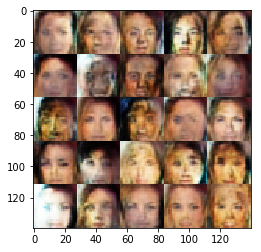

Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 3.1662
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 2.9048
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 2.8923
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 2.8596


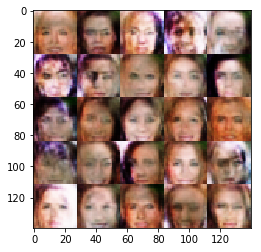

Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 3.1124
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 3.2393
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 2.9482
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 2.8390


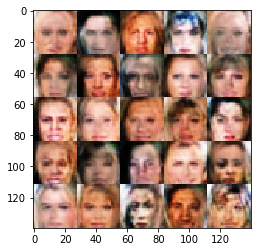

Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 2.7735
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 3.1461
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 3.0028
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 2.8388


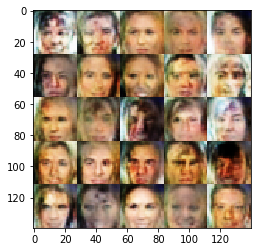

Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 2.8569
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 2.9289
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 2.7690
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 3.0559


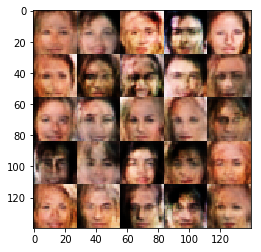

Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 2.9181
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 3.0590
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 2.9177
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 3.3194


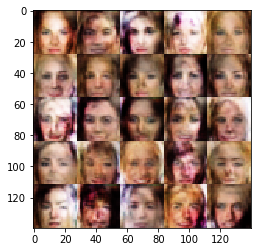

Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 2.8030
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 3.0287
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 3.1364
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 2.9917


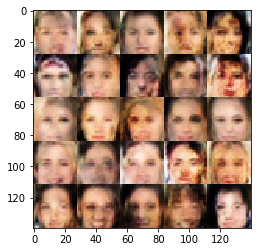

Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 3.0710
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 2.5221
Epoch 1/1... Discriminator Loss: 0.4099... Generator Loss: 2.9033
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 3.1114


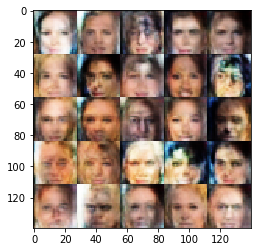

Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 2.8368
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 2.8432
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 3.2930
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 2.9823


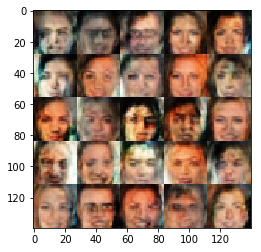

Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 2.8353
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.0377
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 2.9735
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 2.9538


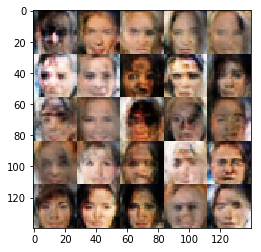

Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 3.1093
Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 2.8294
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 3.0753
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 2.9921


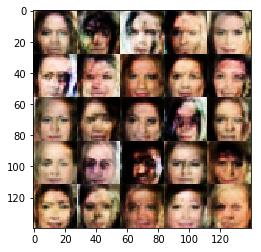

Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.0877
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 2.9966
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 2.9487
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 3.0731


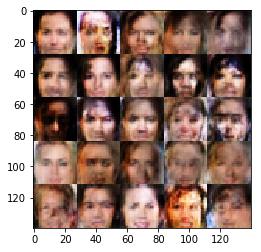

Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 2.8368
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 2.9300
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 2.8821
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 2.9008


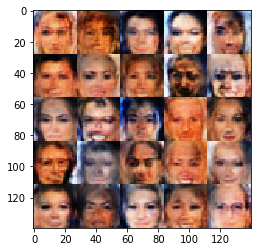

Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 3.0355
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 3.0907
Epoch 1/1... Discriminator Loss: 0.3875... Generator Loss: 3.1605
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 3.2478


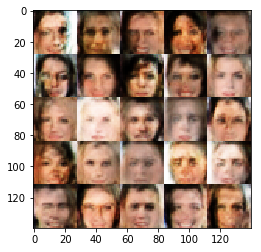

Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 2.8965
Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 2.9955
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 3.0228
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 3.0541


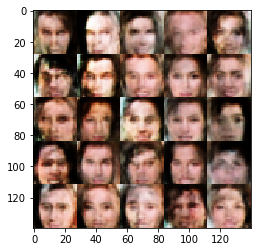

Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 3.1497
Epoch 1/1... Discriminator Loss: 0.3901... Generator Loss: 3.0629
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 3.0321
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 3.1463


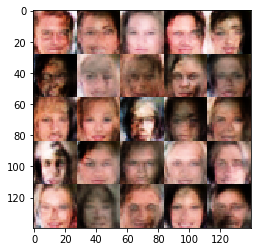

Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 3.0407
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 2.8504
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 2.8032
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 2.8971


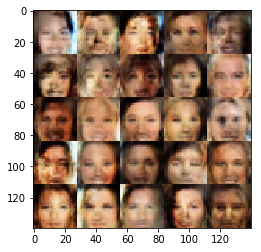

Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 3.0632
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 3.1125
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 2.9236
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 2.8758


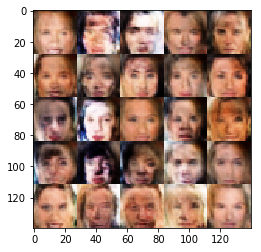

Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 2.9361
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 2.9764
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 3.0139
Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 2.8958


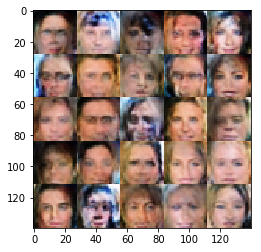

Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 3.0459
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 3.0004
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 2.8894
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 2.9027


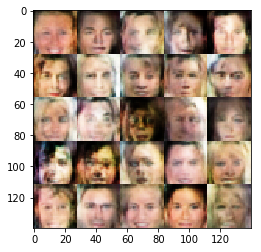

Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 2.8708
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 2.8447
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 3.0806
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 2.9729


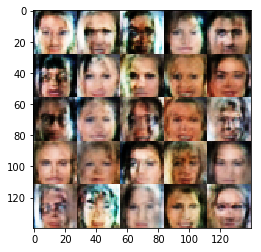

Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 3.0670
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 2.9047
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.1154
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 3.1177


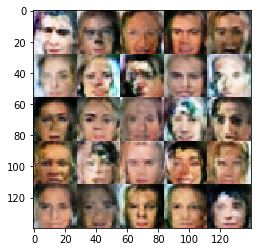

Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 2.8229
Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 2.8842
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 3.2145
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 2.9427


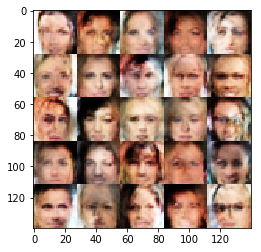

Epoch 1/1... Discriminator Loss: 0.3875... Generator Loss: 3.0400
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 2.8783
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 2.9438
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 3.0068


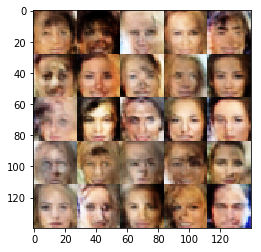

Epoch 1/1... Discriminator Loss: 0.3915... Generator Loss: 2.9297
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 2.9683
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 2.9823
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 3.0023


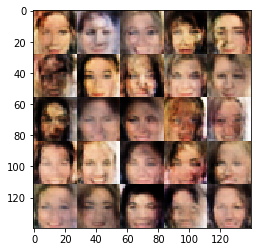

Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 2.9782
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 2.9971
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 3.0488
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 2.9756


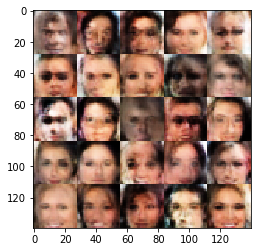

Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 3.0821
Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 3.0257
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 2.9113
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 2.8778


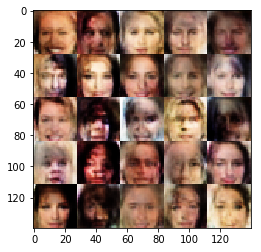

Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 2.8455
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 3.1811
Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 2.9626
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 3.1888


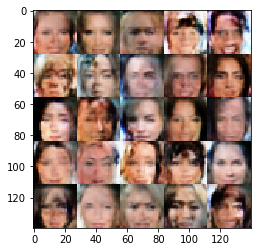

Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 3.1383
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 3.0709
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 3.1953
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 3.0714


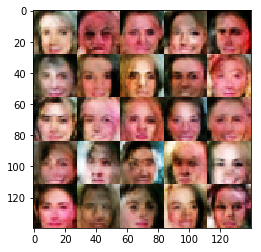

Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 3.0575
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 2.9341
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 2.9503
Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 3.0268


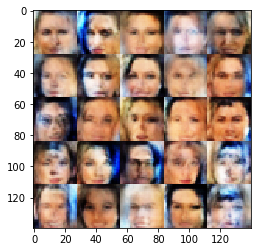

Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 3.0310
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 2.9833
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 3.0046
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 2.8810


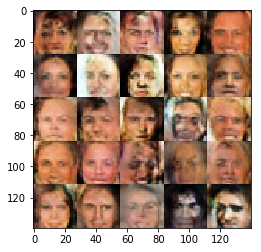

Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 2.8521
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 2.8901
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 2.8590
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 2.9233


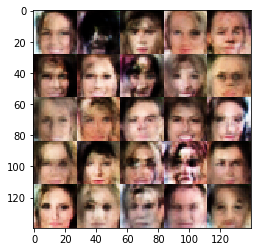

Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 2.8965
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 2.9647
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 3.0429
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 3.0885


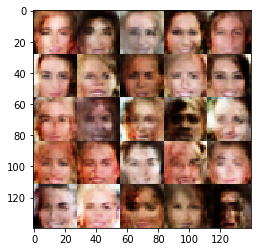

Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 2.9271
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 2.9841
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 3.0529
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 2.7922


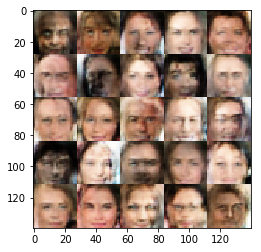

Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 2.7977
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 2.9659
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 3.0790
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 2.9606


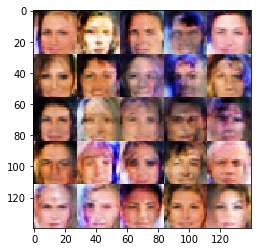

Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 3.0470
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 2.9459
Epoch 1/1... Discriminator Loss: 0.3986... Generator Loss: 2.9804
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 2.8738


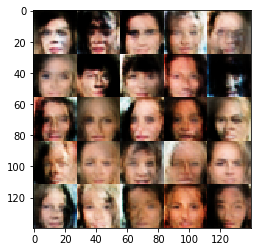

Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 2.9168
Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 3.0680
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 2.8548
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 2.9591


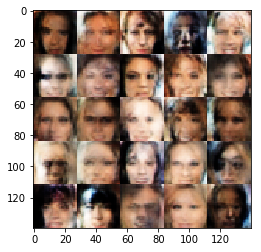

Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 2.9650
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 3.1606
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 2.8222
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 3.1876


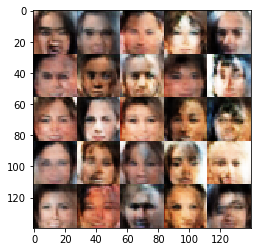

Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 2.9775
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 2.9172
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 3.0459
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 2.9489


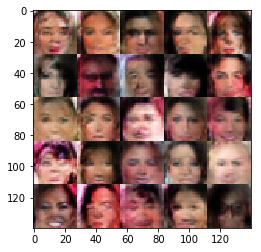

Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 3.0755


In [13]:
z_dim = 100
learning_rate = 0.0001
batch_size = 16
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.